In [1]:
import sys as _sys
import warnings as _wrn
import numpy as _nmp
import numpy.random as _rnd
import matplotlib.pyplot as _plt
import pandas as _pnd

%load_ext autoreload
%autoreload 2
%matplotlib inline

_wrn.filterwarnings('always')
_plt.style.use('ggplot')

In [3]:
import eQTLseq as _assoc

Fitting gene 12612 of 12613
540 genes did not converge
/Users/dimitris/VEnvs/py35/lib/python3.5/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/Users/dimitris/VEnvs/py35/lib/python3.5/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


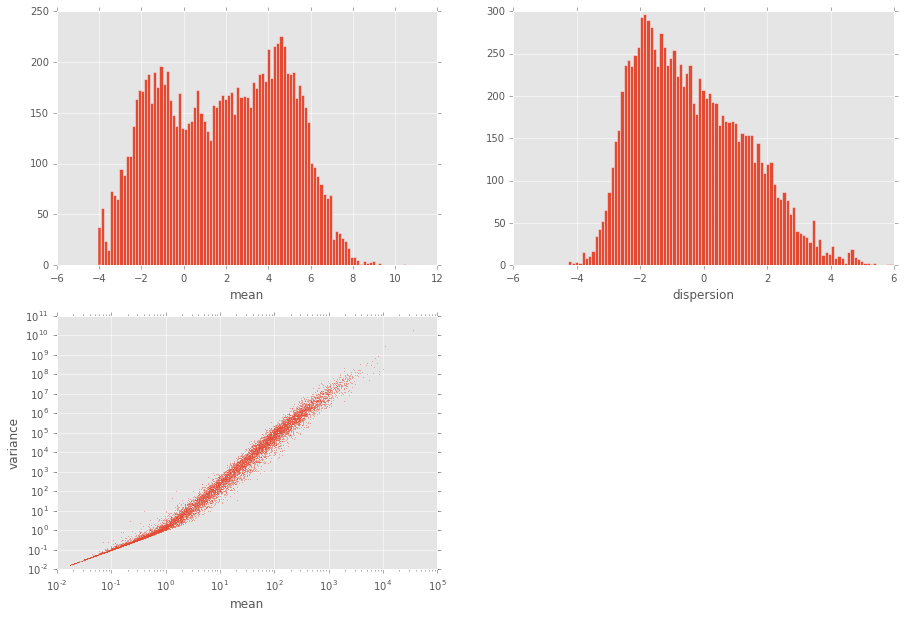

In [4]:
def fcn(fname):
    counts_CEU = _pnd.read_table(fname, index_col=0).values
    counts_CEU = counts_CEU[counts_CEU.sum(1)>0, :]  # remove zero-sum rows
    fit = _assoc.fit_nbinom_model(counts_CEU)
    print('{} genes did not converge'.format((~fit['converged']).sum()), file=_sys.stderr)
    idxs = (fit['converged']) & (_nmp.log(fit['phi']) > -10)
    pars = {'mu': fit['mu'][idxs], 'phi': fit['phi'][idxs]}
    
    return pars

##
pars = fcn('data/montpick_count_table_CEU.txt')

_plt.figure(figsize=(15,10))
_plt.subplot(2,2,1); _plt.hist(_nmp.log(pars['mu']), 100); _plt.xlabel('mean')
_plt.subplot(2,2,2); _plt.hist(_nmp.log(pars['phi']), 100); _plt.xlabel('dispersion');
_plt.subplot(2,2,3); _plt.loglog(pars['mu'], pars['mu'] + pars['mu']**2 / pars['phi'], '.', markersize=0.5); _plt.xlabel('mean'); _plt.ylabel('variance');

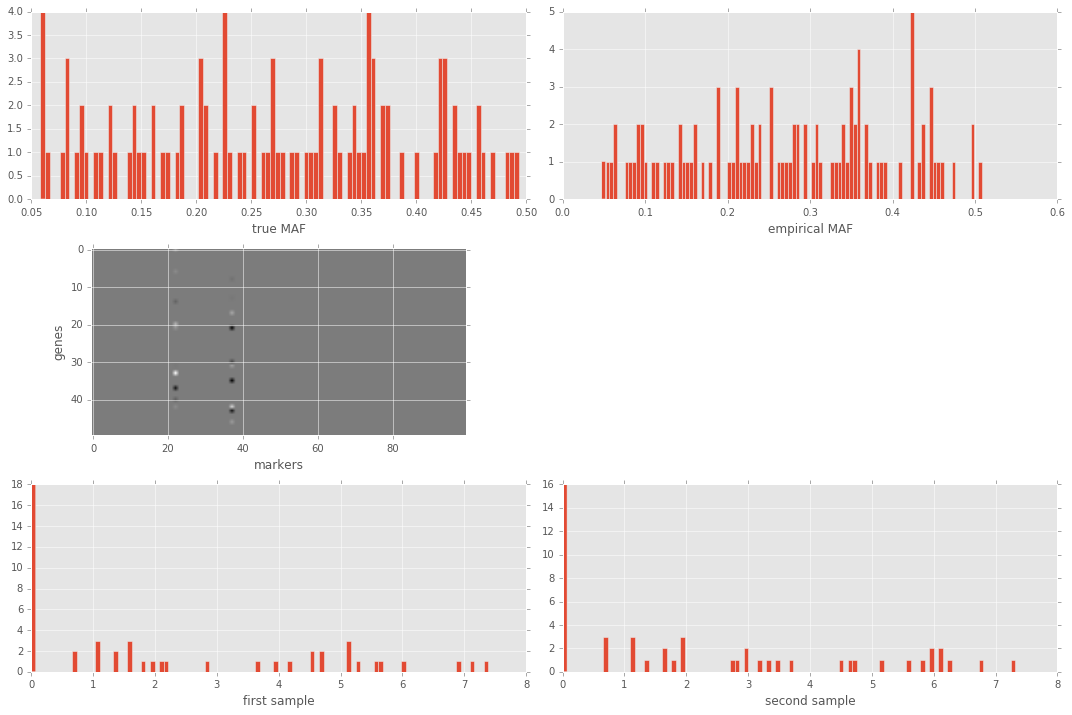

In [5]:
def fcn(n_samples, n_markers, n_markers_causal, n_genes, n_genes_affected, MAF_range):
    data_geno = _assoc.simulate_genotypes(n_samples, n_markers, MAF_range)
    data_pheno = _assoc.simulate_eQTLs_nbinom(data_geno['G'], pars['mu'], pars['phi'], n_markers_causal=n_markers_causal, n_genes=n_genes, n_genes_affected=n_genes_affected, h2=0.5)

    _plt.figure(figsize = (15,10));
    _plt.subplot(3,2,1); _plt.hist(data_geno['MAF'], 100); _plt.xlabel('true MAF')
    _plt.subplot(3,2,2); _plt.hist(data_geno['G'].sum(0) / (2 * n_samples), 100); _plt.xlabel('empirical MAF')
    _plt.subplot(3,2,3); _plt.imshow(data_pheno['beta'], cmap=_plt.cm.gray); _plt.xlabel('markers'); _plt.ylabel('genes')
#     _plt.subplot(3,2,4); _plt.loglog(data_pheno['mu'], data_pheno['mu'] + data_pheno['mu']**2 / data_pheno['phi'], '.'); _plt.xlabel('mean'); _plt.ylabel('variance');
    _plt.subplot(3,2,5); _plt.hist(_nmp.log(data_pheno['Z'][0,:]+1), 100); _plt.xlabel('first sample');
    _plt.subplot(3,2,6); _plt.hist(_nmp.log(data_pheno['Z'][1,:]+1), 100); _plt.xlabel('second sample');
    _plt.tight_layout()
    
    return data_geno, data_pheno

##
data_geno, data_pheno = fcn(n_samples = 1000,
                            n_markers = 100, n_markers_causal = 2,
                            n_genes=50, n_genes_affected = 10,
                            MAF_range = [0.05, 0.5])

In [7]:
state, estim = _assoc.run(data_pheno['Z'], data_geno['G'], n_iters = 1000,
                               mdl='Normal2', alg='Gibbs', 
                               trans='Log', std=True,
                               norm_factors=None, 
                               YY=data_pheno['Y'], phi = data_pheno['phi'], mu = data_pheno['mu'], beta=data_pheno['beta'])    

Preparing data...
Iteration 1000 of 1000
Done!


(7.1717239289839902, 0.69809090651007866, 0.99739999999999995, 0.69767441860465118, 0.75, 0.99839357429718878, 15, 4972, 8, 5)


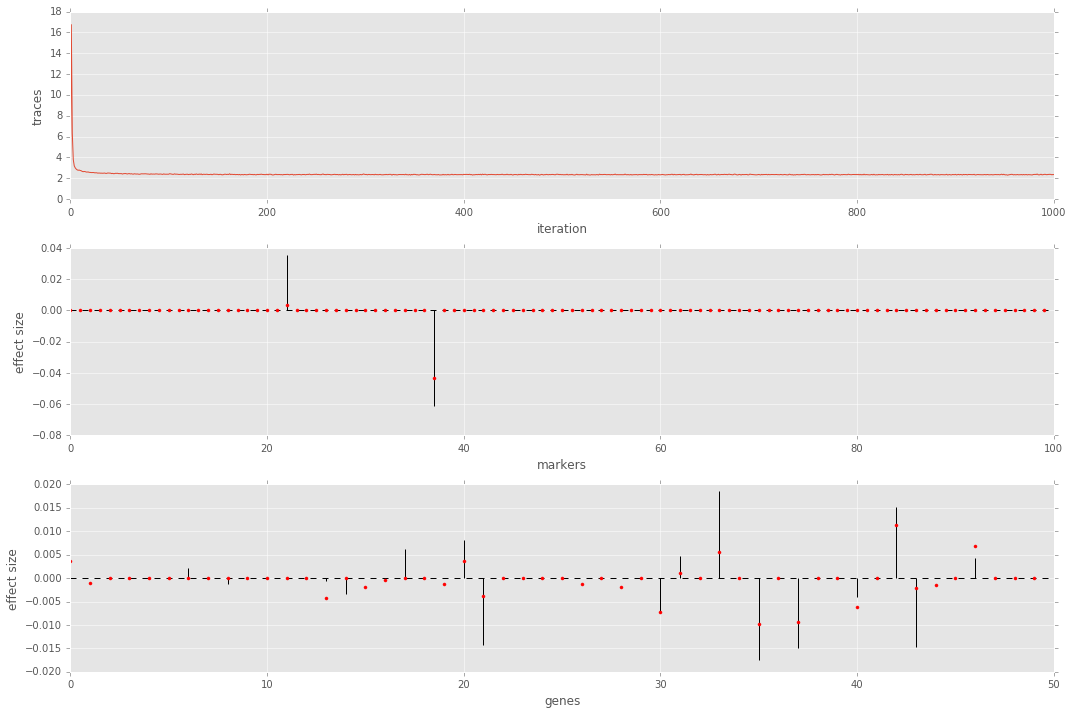

In [8]:
_plt.figure(figsize = (15,10));
_plt.subplot(3,1,1); _plt.plot(state); _plt.xlabel('iteration'); _plt.ylabel('traces')

_plt.subplot(3,1,2); 
_plt.vlines(range(data_pheno['beta'].shape[1]), 0, _nmp.mean(data_pheno['beta'], 0)); 
_plt.axhline(linestyle='--', color='k');
_plt.plot(_nmp.mean(estim['beta'], 0), 'r.'); _plt.xlabel('markers'); _plt.ylabel('effect size')

_plt.subplot(3,1,3); 
_plt.vlines(range(data_pheno['beta'].shape[0]), 0, _nmp.mean(data_pheno['beta'], 1)); 
_plt.axhline(linestyle='--', color='k');
_plt.plot(_nmp.mean(estim['beta'], 1), 'r.'); _plt.xlabel('genes'); _plt.ylabel('effect size')


if 'mu' in estim:
    _plt.figure(figsize = (15,10))
    _plt.subplot(2,2,1)
    _plt.plot(_nmp.log(data_pheno['mu']), _nmp.log(estim['mu']), '.'); _plt.ylim(_plt.xlim()); 
    _plt.plot(_plt.gca().get_xlim(),_plt.gca().get_ylim(), '--k'); 
    _plt.xlabel('true log(mu)'); _plt.ylabel('estimated log(mu)')

if 'phi' in estim:
    _plt.subplot(2,2,2)
    _plt.plot(_nmp.log(data_pheno['phi']), _nmp.log(estim['phi']), '.'); _plt.ylim(_plt.xlim()); 
    _plt.plot(_plt.gca().get_xlim(),_plt.gca().get_ylim(), '--k'); 
    _plt.xlabel('true log(phi)'); _plt.ylabel('estimated log(phi)')


if 'phi' in estim and 'mu' in estim:
    _plt.subplot(2,2,3)
    var = estim['mu'] + estim['phi'] * estim['mu']**2
    _plt.plot(_nmp.log(estim['mu']), _nmp.log(var), '.');
    _plt.xlabel('log(mu)'); _plt.ylabel('log(var)')

    _plt.subplot(2,2,4)
    var_true = data_pheno['mu'] + data_pheno['phi'] * data_pheno['mu']**2
    var_estim = estim['mu'] + estim['phi'] * estim['mu']**2
    _plt.plot(_nmp.log(var_true), _nmp.log(var_estim), '.'); _plt.ylim(_plt.xlim()); 
    _plt.plot(_plt.gca().get_xlim(),_plt.gca().get_ylim(), '--k'); 
    _plt.xlabel('true log(var)'); _plt.ylabel('estimated log(var)')

_plt.tight_layout()
print(_assoc.calculate_metrics(estim['beta'], data_pheno['beta']));

In [ ]:
%pdb

In [ ]:
import ModelNormalGibbs2 as tmp